In [12]:
import requests
from dotenv import load_dotenv

load_dotenv()

url = "https://yh-finance.p.rapidapi.com/auto-complete"

x_rapidapi_key = os.getenv("RAPIDAPI_KEY")

querystring = {"q":"intel","region":"US"}

headers = {
    'x-rapidapi-host': "yh-finance.p.rapidapi.com",
    'x-rapidapi-key': x_rapidapi_key
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"explains":[],"count":15,"quotes":[{"exchange":"NMS","shortname":"Intel Corporation","quoteType":"EQUITY","symbol":"INTC","index":"quotes","score":234927.0,"typeDisp":"Equity","longname":"Intel Corporation","isYahooFinance":true},{"exchange":"PNK","shortname":"ARTIFICIAL INTELLIGENC TECH SOL","quoteType":"EQUITY","symbol":"AITX","index":"quotes","score":75374.0,"typeDisp":"Equity","longname":"Artificial Intelligence Technology Solutions Inc.","isYahooFinance":true},{"exchange":"NGM","shortname":"Intellia Therapeutics, Inc.","quoteType":"EQUITY","symbol":"NTLA","index":"quotes","score":37636.0,"typeDisp":"Equity","longname":"Intellia Therapeutics, Inc.","isYahooFinance":true},{"exchange":"PNK","shortname":"INTELGENX TECHNOLOGIES CORPORAT","quoteType":"EQUITY","symbol":"IGXT","index":"quotes","score":33795.0,"typeDisp":"Equity","longname":"IntelGenx Technologies Corp.","isYahooFinance":true},{"exchange":"NGM","shortname":"Faraday Future Intelligent Elec","quoteType":"EQUITY","symbol":"F

[*********************100%***********************]  14 of 14 completed


,Bool
0,True
1,False
2,False
3,False
4,False
...,...
3458,False
3459,False
3460,False
3461,False


(3463, 15)

Date  Adj Close                                                \
                       BAC        BNY           C         COF       FITB   
0    2007-12-31  32.754990   7.075705  241.277390   37.507050  17.455114   
1    2008-01-02  32.199276   7.200171  237.015762   37.578484  16.955008   
2    2008-01-03  31.992872   7.490572  237.097595   37.038803  17.066132   
3    2008-01-04  31.635632   7.495180  231.442657   36.483269  16.517414   
4    2008-01-07  31.675335   7.536670  231.606750   37.181660  16.135380   
...         ...        ...        ...         ...         ...        ...   
3458 2021-09-24  42.139999  15.501804   71.180000  166.169998  41.224182   
3459 2021-09-27  43.259998  15.442028   72.260002  169.759995  43.299793   
3460 2021-09-28  43.160000  15.322477   71.370003  167.380005  43.270000   
3461 2021-09-29  43.070000  15.222851   71.529999  166.550003  43.340000   
3462 2021-09-30        NaN        NaN         NaN         NaN        NaN   

                                                                            \
              GS         JPM        KEY          MS         PNC        STT   
0     176.851135   30.623217  16.262436   41.159161   46.057644  62.845276   
1     170.724472   29.844727  15.811662   39.485203   45.412205  61.049702   
2     168.454666   29.639481  15.721512   39.477448   44.900066  66.072701   
3     164.416870   28.967142  15.145918   38.206490   43.882786  63.325157   
4     160.140472   29.257315  15.416377   37.439255   44.528229  63.766312   
...          ...         ...        ...         ...         ...        ...   
3458  390.850006  162.063416  21.139999  102.910004  193.294983  85.175270   
3459  399.809998  165.979828  21.820000  105.099998  198.959656  87.887291   
3460  389.500000  165.085220  21.750000  102.040001  196.495026  86.238220   
3461  384.890015  164.955994  21.990000   99.550003  196.216766  85.970001   
3462         NaN         NaN        NaN         NaN         NaN        NaN   

                                       
             TD        USB        WFC  
0     20.286037  22.160822  20.739820  
1     20.107944  21.769831  19.991018  
2     20.043613  21.176363  19.592571  
3     19.587408  20.554966  18.884983  
4     19.119511  20.743479  19.015507  
...         ...        ...        ...  
3458  65.162842  59.334797  47.919998  
3459  66.460754  60.634823  47.560001  
3460  66.361679  59.959999  45.919998  
3461  65.975273  60.259998  47.029999  
3462        NaN        NaN        NaN  

[3463 rows x 15 columns]

Adj Close                                                \
                  BAC        BNY           C         COF       FITB   
Date                                                                  
2007-12-31  32.754990   7.075705  241.277390   37.507050  17.455114   
2008-01-02  32.199276   7.200171  237.015762   37.578484  16.955008   
2008-01-03  31.992872   7.490572  237.097595   37.038803  17.066132   
2008-01-04  31.635632   7.495180  231.442657   36.483269  16.517414   
2008-01-07  31.675335   7.536670  231.606750   37.181660  16.135380   
...               ...        ...         ...         ...        ...   
2021-09-24  42.139999  15.501804   71.180000  166.169998  41.224182   
2021-09-27  43.259998  15.442028   72.260002  169.759995  43.299793   
2021-09-28  43.160000  15.322477   71.370003  167.380005  43.270000   
2021-09-29  43.070000  15.222851   71.529999  166.550003  43.340000   
2021-09-30        NaN        NaN         NaN         NaN        NaN   

                                                                       \
                    GS         JPM        KEY          MS         PNC   
Date                                                                    
2007-12-31  176.851135   30.623217  16.262436   41.159161   46.057644   
2008-01-02  170.724472   29.844727  15.811662   39.485203   45.412205   
2008-01-03  168.454666   29.639481  15.721512   39.477448   44.900066   
2008-01-04  164.416870   28.967142  15.145918   38.206490   43.882786   
2008-01-07  160.140472   29.257315  15.416377   37.439255   44.528229   
...                ...         ...        ...         ...         ...   
2021-09-24  390.850006  162.063416  21.139999  102.910004  193.294983   
2021-09-27  399.809998  165.979828  21.820000  105.099998  198.959656   
2021-09-28  389.500000  165.085220  21.750000  102.040001  196.495026   
2021-09-29  384.890015  164.955994  21.990000   99.550003  196.216766   
2021-09-30         NaN         NaN        NaN         NaN         NaN   

                                                            Bool  
                  STT         TD        USB        WFC Month_End  
Date                                                              
2007-12-31  62.845276  20.286037  22.160822  20.739820      True  
2008-01-02  61.049702  20.107944  21.769831  19.991018     False  
2008-01-03  66.072701  20.043613  21.176363  19.592571     False  
2008-01-04  63.325157  19.587408  20.554966  18.884983     False  
2008-01-07  63.766312  19.119511  20.743479  19.015507     False  
...               ...        ...        ...        ...       ...  
2021-09-24  85.175270  65.162842  59.334797  47.919998     False  
2021-09-27  87.887291  66.460754  60.634823  47.560001     False  
2021-09-28  86.238220  66.361679  59.959999  45.919998     False  
2021-09-29  85.970001  65.975273  60.259998  47.029999     False  
2021-09-30        NaN        NaN        NaN        NaN      True  

[3463 rows x 15 columns]

Adj Close                                                          \
                  BAC       BNY           C        COF       FITB          GS   
Date                                                                            
2007-12-31  32.754990  7.075705  241.277390  37.507050  17.455114  176.851135   
2008-01-31  35.049271  7.774827  233.549713  43.348183  18.823462  164.393112   
2008-02-29  31.548317  7.102755  196.573074  36.809406  15.906166  139.744476   
2008-03-31  30.600548  7.337273  177.587341  39.360394  14.822286  136.251541   
2008-04-30  30.301884  7.568946  209.506577  42.383198  15.183631  157.947128   

                                                                              \
                  JPM        KEY         MS        PNC        STT         TD   
Date                                                                           
2007-12-31  30.623217  16.262436  41.159161  46.057644  62.845276  20.286037   
2008-01-31  33.546124  18.127937  38.461285  46.499046  63.557320  19.797956   
2008-02-29  28.768978  15.539409  32.833183  43.543236  60.794327  19.602032   
2008-03-31  30.396761  15.468934  35.623848  46.477783  61.317924  17.940992   
2008-04-30  33.997936  17.005255  38.100464  49.652794  55.993351  19.412348   

                                      Bool  
                  USB        WFC Month_End  
Date                                        
2007-12-31  22.160822  20.739820      True  
2008-01-31  23.452486  23.412153      True  
2008-02-29  22.356316  20.286715      True  
2008-03-31  22.880552  20.196499      True  
2008-04-30  23.962364  20.647608      True

Adj Close                                               \
                  BAC        BNY          C         COF       FITB   
Date                                                                 
2021-03-31  38.331387  15.009153  71.712051  125.971199  36.932526   
2021-04-30  40.154335  14.145668  70.711990  147.605026  39.979828   
2021-06-30  41.019794  14.875613  70.225624  153.552505  37.966766   
2021-08-31  41.537144  15.165728  71.910004  165.970001  38.592430   
2021-09-30        NaN        NaN        NaN         NaN        NaN   

                                                                       \
                    GS         JPM        KEY          MS         PNC   
Date                                                                    
2021-03-31  324.323425  149.570267  19.645620   76.767990  172.055862   
2021-04-30  345.597870  152.012711  21.395832   81.948517  184.558670   
2021-06-30  377.694733  153.722504  20.467125   91.021912  188.319931   
2021-08-31  413.510010  158.991928  20.320000  104.430000  189.916046   
2021-09-30         NaN         NaN        NaN         NaN         NaN   

                                                            Bool  
                  STT         TD        USB        WFC Month_End  
Date                                                              
2021-03-31  82.928719  63.416382  54.488258  38.816006      True  
2021-04-30  82.869484  67.496017  58.468235  44.757126      True  
2021-06-30  81.738060  68.772308  56.536266  45.093727      True  
2021-08-31  92.298050  64.340515  56.953068  45.700001      True  
2021-09-30        NaN        NaN        NaN        NaN      True

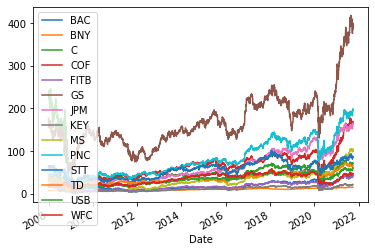

In [131]:
#import required libraries

import yfinance as yf
import pandas as pd

#download and load data into variable for top 14 banks from 2008 to 2021
data = yf.download("JPM BAC C WFC GS MS PNC USB COF BNY STT KEY FITB TD", start="2007-12-31", end="2021-09-30")

#create dataframe
stock_data = pd.DataFrame(data)

#drop all columns except Adj Close and confirm the new size has much less columns
stock_data.drop(columns=["Volume","Open","Low","High","Close"],axis=1,level=0,inplace=True)
display(stock_data.shape)

#extract the date index as a series
s = pd.Series(stock_data.index)

#use a function to check and convert month_end dates as True and create as a DataFrame
x = pd.DataFrame(s.dt.is_month_end)

#Rename "Date" column to avoid name conflict later on when merging
x.rename(columns={"Date": "Bool"},inplace=True)

#display new dataframe to confirm column renamed from Date to Bool
display(x)

#Add an additional name to the multi-level column
x.columns = pd.MultiIndex.from_product([x.columns,["Month_End"]]) 

#reset original index on stock data frame so that the merge occurs on a numeric index and confirm data no longer index
stock_data.reset_index(inplace=True)
display(stock_data)

#create new dataframe by merging on both left and right index
z = stock_data.merge(x,left_index=True,right_index=True)

#create new copy in order to reset the index back to data so plotting is easier
zz = z.copy()
zz.set_index("Date",inplace=True)
display(zz)
zz.to_csv("stockdata.csv")

#Plot all data points to review high-level trend
zz["Adj Close"].plot()

#Using the "Bool" column from the new merged dataframe only extra data at month_end and confirm using head and tail
month_end_df = zz[zz["Bool"]["Month_End"] == True]
display(month_end_df.head())
display(month_end_df.tail())

In [100]:
import yahoo_fin.stock_info as si

si.get_income_statement("WFC",yearly=True)

endDate,2020-12-31,2019-12-31,2018-12-31,2017-12-31
Breakdown,,,,
researchDevelopment,None,None,None,None
effectOfAccountingCharges,None,None,None,None
incomeBeforeTax,581000000,24198000000,28538000000,27377000000
minorityInterest,1033000000,838000000,900000000,1143000000
netIncome,3301000000,19549000000,22393000000,22183000000
sellingGeneralAdministrative,49501000000,50325000000,47655000000,40422000000
grossProfit,58319000000,82458000000,84696000000,85989000000
ebit,0,0,0,0
operatingIncome,2117000000,24198000000,28538000000,29816000000


In [11]:
import requests
import json
import pandas as pd
from sec_api import XbrlApi, QueryApi

from dotenv import load_dotenv

load_dotenv()

SEC_API_KEY = os.getenv("SEC_API_KEY")

query_api = QueryApi(api_key=SEC_API_KEY)

filing_url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0000070858/000007085821000023/bac-20201231.htm"

# get your API key at https://sec-api.io
# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_url + "&token=" + SEC_API_KEY

# make request to the API
response = requests.get(final_url)

# load JSON into memory
xbrl_json = json.loads(response.text)

# income statement example
print(xbrl_json['StatementsOfIncome'])



# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        if usGaapItem == "NetIncomeLoss":
            values = []
            indicies = []
        
            
            for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
                # only consider items without segment. not required for our analysis.
                if 'segment' not in fact:
                    index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                    # ensure no index duplicates are created
                    if index not in indicies:
                        values.append(fact['value'])
                        indicies.append(index)                    

            income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 
        
    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 

income_statement = get_income_statement(xbrl_json)

# fetch all 10-Q and 10-K filings for WFC
query = {
    "query": {
        "query_string": {
            "query": "(formType:\"10-K\") AND ticker:BAC"
        }
    },
    "from": "0",
    "size": "20",
    "sort": [{ "filedAt": { "order": "desc" } }]
}

query_result = query_api.get_filings(query)

print(query_result)

accession_numbers = []

# extract accession numbers of each filing
for filing in query_result['filings']:
    accession_numbers.append(filing['accessionNo']);
    
# get XBRL-JSON for a given accession number
def get_xbrl_json(accession_no):
    request_url = xbrl_converter_api_endpoint + "?accession-no=" + accession_no + "&token=" + SEC_API_KEY

    response_tmp = requests.get(request_url)

    return json.loads(response_tmp.text)

# merge two income statements into one statement.
# row indicies of both statements have to be the same
# statement_b represents the most recent statement.
def merge_income_statements(statement_a, statement_b):
    return statement_a.merge(statement_b,
                     how="outer", 
                     #on="i_s.index", 
                     left_index=True,
                     right_index=True,
                     suffixes=('_left', ''))

# clean income statement.
# drop duplicate columns (= column name ends with "_left"), drop key_0 column, drop columns with +5 NaNs
def clean_income_statement(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

# helps printing dataframes while we generate new income statement
from IPython.display import display, HTML

previous_income_statement_set = False
income_statement_final = None

for accession_no in accession_numbers:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print(accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    xbrl_json_data = get_xbrl_json(accession_no)
    
    # convert XBRL-JSON to a pandas dataframe
    income_statement_uncleaned = get_income_statement(xbrl_json_data)

    # clean the income statement
    income_statement_cleaned = clean_income_statement(income_statement_uncleaned)
    
    # print income statement on each iteration to monitor progress
    display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    if previous_income_statement_set:
        income_statement_final = clean_income_statement(merge_income_statements(income_statement_final, income_statement_cleaned))
        income_statement_final.to_excel("file_BAC.xlsx")
    else:
        income_statement_final = income_statement_cleaned
        previous_income_statement_set = True


{'InterestAndDividendIncomeOperating': [{'decimals': '-6', 'unitRef': 'usd', 'period': {'startDate': '2020-01-01', 'endDate': '2020-12-31'}, 'value': '51585000000'}, {'decimals': '-6', 'unitRef': 'usd', 'period': {'startDate': '2019-01-01', 'endDate': '2019-12-31'}, 'value': '71236000000'}, {'decimals': '-6', 'unitRef': 'usd', 'period': {'startDate': '2018-01-01', 'endDate': '2018-12-31'}, 'value': '66769000000'}], 'InterestExpense': [{'decimals': '-6', 'unitRef': 'usd', 'period': {'startDate': '2020-01-01', 'endDate': '2020-12-31'}, 'value': '8225000000'}, {'decimals': '-6', 'unitRef': 'usd', 'period': {'startDate': '2019-01-01', 'endDate': '2019-12-31'}, 'value': '22345000000'}, {'decimals': '-6', 'unitRef': 'usd', 'period': {'startDate': '2018-01-01', 'endDate': '2018-12-31'}, 'value': '18607000000'}], 'InterestIncomeExpenseNet': [{'decimals': '-6', 'unitRef': 'usd', 'period': {'startDate': '2020-01-01', 'endDate': '2020-12-31'}, 'value': '43360000000'}, {'decimals': '-6', 'unitRef'

,2018-01-01-2018-12-31,2019-01-01-2019-12-31,2020-01-01-2020-12-31
NetIncomeLoss,28147000000,27430000000,17894000000


0000070858-20-000011


,2017-01-01-2017-12-31,2018-01-01-2018-12-31,2019-01-01-2019-12-31
NetIncomeLoss,18232000000,28147000000,27430000000


0000070858-19-000012


,2016-01-01-2016-12-31,2017-01-01-2017-12-31,2018-01-01-2018-12-31
NetIncomeLoss,17822000000,18232000000,28147000000


0000070858-18-000009


KeyError: 'StatementsOfIncome'